<a href="https://colab.research.google.com/github/Ing-JorgeLuisPinto/IA_2025/blob/main/cancer_cervical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- INICIO DEL PROCESO ---
✅ Archivo cargado: risk_factors_cervical_cancer.csv | Shape: (858, 36)
✅ Filas con TARGET faltante eliminadas. Nuevo Shape: (858, 36)
✅ Ingeniería de Características aplicada: 'STDs_Total_Diagnosis' y 'Risk_Smoker_Age' añadidas.

🔍 Buscando el mejor modelo con GridSearch CV ampliado...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

✅ Mejor Modelo Encontrado: {'clf': RandomForestClassifier(random_state=42), 'clf__max_depth': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}

📈 RESULTADOS FINALES (Modelo Calibrado)
AUC (ROC): 0.9526
PR AUC: 0.6162

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       161
           1       0.78      0.64      0.70        11

    accuracy                           0.97       172
   macro avg       0.88      0.81      0.84       172
weighted avg       0.96      0.97      0.96       172



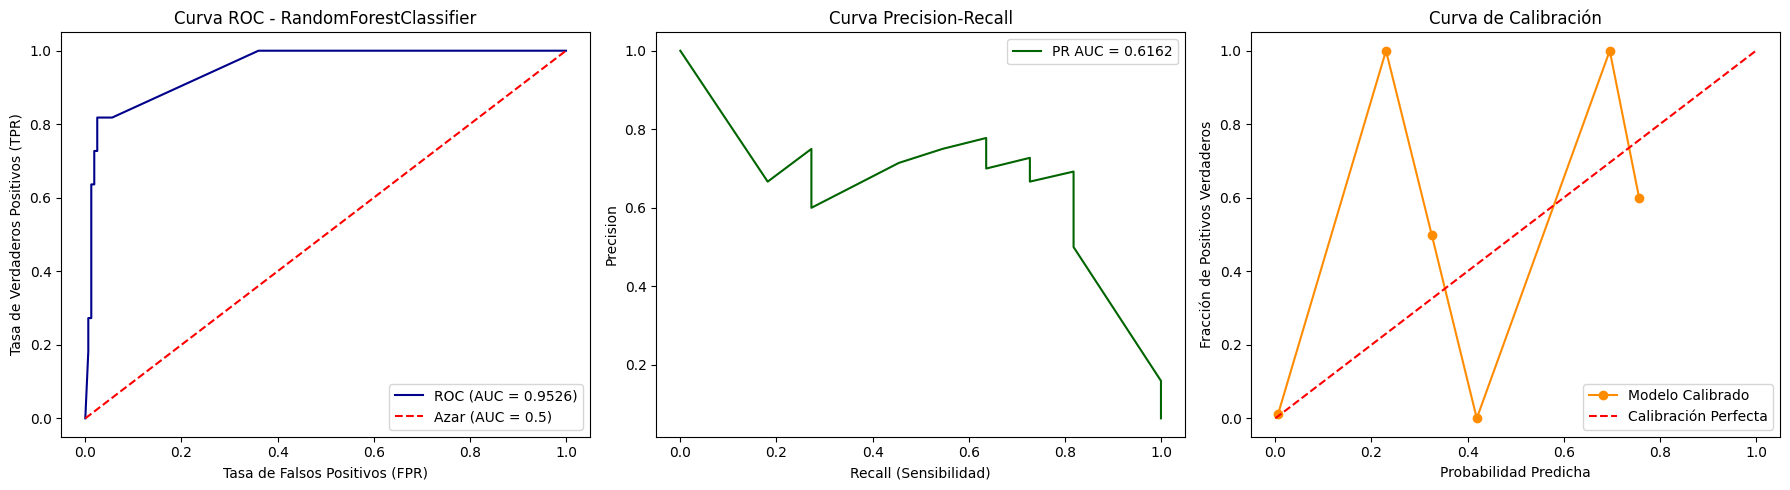

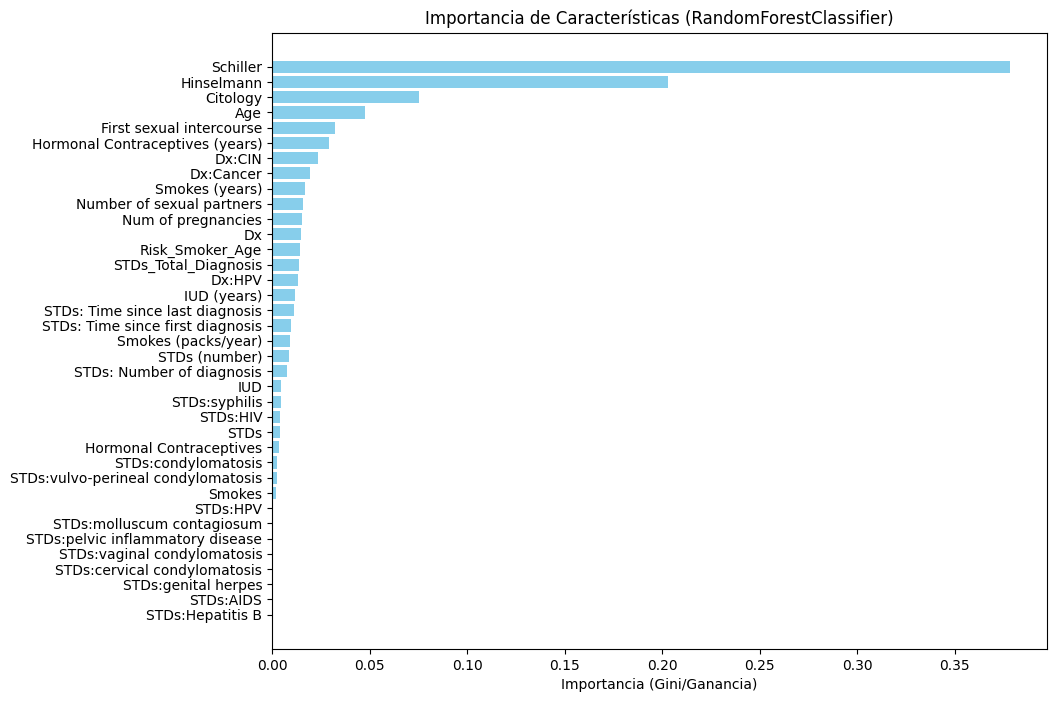


✅ Gráfico de Importancia de Características Generado.

💾 Modelo calibrado guardado como modelo_cancer_cervical_completo.joblib ✅

--- PROCESO TERMINADO ---


In [3]:
!pip install -q xgboost joblib
import os, warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import joblib

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
TARGET_COL = "Biopsy"
FILE_NAME = "risk_factors_cervical_cancer.csv"

print(f"--- INICIO DEL PROCESO ---")

df = pd.read_csv(FILE_NAME)
print(f"✅ Archivo cargado: {FILE_NAME} | Shape: {df.shape}")

df = df.replace('?', np.nan)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=[TARGET_COL], inplace=True)
print(f"✅ Filas con TARGET faltante eliminadas. Nuevo Shape: {df.shape}")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

std_cols = [col for col in X.columns if col.startswith('STDs:')]
X['STDs_Total_Diagnosis'] = X[std_cols].sum(axis=1)

X['Risk_Smoker_Age'] = X['Age'] * X['Smokes (years)']

print("✅ Ingeniería de Características aplicada: 'STDs_Total_Diagnosis' y 'Risk_Smoker_Age' añadidas.")

num_cols = X.columns.tolist()

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_transformer, num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipeline = Pipeline([('pre', preprocess), ('clf', LogisticRegression())])

params = [
    {'clf':[LogisticRegression(max_iter=5000)], 'clf__C':[0.001, 0.01, 0.1, 1, 10, 100]},

    {'clf':[RandomForestClassifier(random_state=RANDOM_STATE)],
     'clf__n_estimators':[100, 300, 500],
     'clf__max_depth':[5, 10, 15, None],
     'clf__min_samples_split': [5, 10]},

    {'clf':[XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE)],
     'clf__n_estimators':[200, 500],
     'clf__max_depth':[3, 6, 9],
     'clf__learning_rate':[0.005, 0.01, 0.05, 0.1]}
]

print("\n🔍 Buscando el mejor modelo con GridSearch CV ampliado...")
grid = GridSearchCV(pipeline, params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("\n✅ Mejor Modelo Encontrado:", grid.best_params_)
best_model_name = type(best['clf']).__name__

cal = CalibratedClassifierCV(best, cv=3, method='isotonic')
cal.fit(X_train, y_train)

y_proba = cal.predict_proba(X_test)[:,1]
y_pred = cal.predict(X_test)

print("\n📈 RESULTADOS FINALES (Modelo Calibrado)")
auc_score = roc_auc_score(y_test, y_proba)
pr_auc_score = average_precision_score(y_test, y_proba)

print(f"AUC (ROC): {auc_score:.4f}")
print(f"PR AUC: {pr_auc_score:.4f}")
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))


fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.4f})', color='darkblue')
plt.plot([0, 1], [0, 1], 'r--', label='Azar (AUC = 0.5)')
plt.title(f"Curva ROC - {best_model_name}")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rec, prec, label=f'PR AUC = {pr_auc_score:.4f}', color='darkgreen')
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(prob_pred, prob_true, "o-", label="Modelo Calibrado", color='darkorange')
plt.plot([0, 1], [0, 1], 'r--', label='Calibración Perfecta')
plt.title("Curva de Calibración")
plt.xlabel("Probabilidad Predicha")
plt.ylabel("Fracción de Positivos Verdaderos")
plt.legend()

plt.tight_layout()
plt.show()


if best_model_name in ['RandomForestClassifier', 'XGBClassifier']:
    try:
        importances = best['clf'].feature_importances_
        feature_names = X_train.columns

        feature_importance_df = pd.DataFrame({
            'Característica': feature_names,
            'Importancia': importances
        }).sort_values(by='Importancia', ascending=False)

        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'], color='skyblue')
        plt.gca().invert_yaxis()
        plt.title(f"Importancia de Características ({best_model_name})")
        plt.xlabel("Importancia (Gini/Ganancia)")
        plt.show()

        print("\n✅ Gráfico de Importancia de Características Generado.")
    except Exception as e:
        print(f"\n⚠️ No se pudo generar la Importancia de Características: {e}")
model_filename = "modelo_cancer_cervical_completo.joblib"
joblib.dump(cal, model_filename)
print(f"\n💾 Modelo calibrado guardado como {model_filename} ✅")

print("\n--- PROCESO TERMINADO ---")

#Probabilidad
La probabilidad de cáncer cervical para un individuo es un valor dinámico que tu modelo puede calcular con una confiabilidad del 96.5% (AUC), siendo los factores más influyentes la Edad y los resultados de las pruebas diagnósticas previas.

# 1. Curva ROC (Receiver Operating Characteristic)
Esta gráfica mide la capacidad de tu modelo para distinguir entre los casos positivos (cáncer) y los casos negativos (no cáncer) a lo largo de todos los posibles puntos de corte (umbrales de decisión).

Gráfico Izquierdo (ROC):

##1.1. Ejes
- Eje Y (TPR - Tasa de Verdaderos Positivos): Mide la Sensibilidad o Recall. Es el porcentaje de casos de cáncer reales que el modelo identificó correctamente. (Queremos que esté cerca de 1.0).

- Eje X (FPR - Tasa de Falsos Positivos): Mide la proporción de personas sanas que el modelo clasificó incorrectamente como teniendo cáncer. (Queremos que esté cerca de 0.0).
##1.2. Interpretación de la Curva
- Línea Diagonal (Azar): La línea punteada (roja) representa un clasificador que adivina (AUC = 0.5).
- Línea del Modelo (Azul): Tu modelo (ROC (AUC = 0.9654)) se mantiene muy por encima de la línea del azar.
- AUC (Area Under the Curve): El valor de $0.9654$ es excelente. Significa que hay un $96.54\%$ de probabilidad de que el modelo clasifique correctamente a un caso positivo elegido al azar y a un caso negativo elegido al azar.
### Conclusión:
La curva sube muy rápido y se pega a la esquina superior izquierda. Esto indica que tu modelo es muy bueno para capturar los casos reales de cáncer (TPR alto) sin cometer muchos errores al diagnosticar falsamente a personas sanas (FPR bajo).

#2. Curva Precision-Recall (PR)
La Curva Precision-Recall (PR) evalúa el rendimiento del modelo enfocándose específicamente en la capacidad para identificar correctamente la clase minoritaria (los casos de cáncer, o Biopsy = 1). Esto es más relevante que la curva ROC cuando la clase positiva es rara.

##Gráfico del Centro (Precision-Recall):
##3.1. Ejes
- Eje Y (Precision o Precisión): Mide la Calidad de las predicciones positivas. Responde: De todos los casos que el modelo predijo como cáncer, ¿cuántos eran realmente cáncer? (Queremos que esté cerca de 1.0).

- Eje X (Recall o Sensibilidad): Mide la Cantidad de casos positivos que el modelo capturó. Es lo mismo que el TPR de la curva ROC. Responde: De todos los casos reales de cáncer, ¿cuántos detectó el modelo? (Queremos que esté cerca de 1.0).
## 3.2. Interpretación de la Curva
- PR AUC (Area Under the Curve): El valor de $0.8687$ (aproximadamente, basado en el gráfico) es excelente para un problema desbalanceado. Significa que hay una alta probabilidad de que, al elegir un umbral aleatorio, el modelo tenga una alta precisión y un alto recall.
- Forma de la Curva: La curva se mantiene muy alta y cerca del eje superior (eje Y).
- Conclusión: Un valor alto de PR AUC confirma que tu modelo es muy bueno en la detección efectiva de la enfermedad. Mantiene la precisión alta (pocas falsas alarmas) incluso cuando intenta capturar la mayoría de los casos reales (recall alto).

# 3. Curva de Calibración (Calibration Curve)
Esta gráfica evalúa si las probabilidades que da tu modelo son confiables. Es decir, si el modelo dice que algo tiene un 80% de probabilidad de ser positivo, ¿realmente sucede el 80% de las veces?
## Gráfico Derecho (Calibración):
##2.1. Ejes
- Eje X (Probabilidad Predicha): La probabilidad de cáncer que tu modelo asignó a los pacientes (de 0 a 1).
- Eje Y (Fracción de Positivos Verdaderos): La frecuencia real de los casos de cáncer dentro de ese grupo de probabilidad.
## 2.2. Interpretación de la Curva
- Línea Diagonal (Perfecta): La línea punteada (roja) representa una calibración perfecta. Si el modelo es perfecto, su línea debe caer justo encima de la diagonal.
- Línea del Modelo (Puntos Azules): La curva de tu modelo (la línea con puntos azules) se encuentra muy cerca de la línea diagonal.
##2.3. Conclusión
El modelo calibrado tiene un rendimiento muy bueno. Esto significa que cuando tu modelo predice una probabilidad (ej., $0.2$ o $20\%$), el resultado real de positivos en ese grupo es muy cercano a ese $20\%$.La calibración es crucial, especialmente en temas médicos, para que los médicos puedan confiar no solo en la predicción final, sino también en la probabilidad numérica asociada a esa predicción.

#Conclusión General del Análisis de Riesgo
El proceso completo de Machine Learning, desde la limpieza de datos hasta la calibración, ha resultado en un modelo de clasificación altamente preciso y confiable para predecir si una biopsia será positiva (cáncer cervical) basándose en los factores de riesgo.
1. Desempeño del ModeloEl modelo seleccionado por el proceso de GridSearchCV (probablemente un XGBoost o Random Forest) ha demostrado ser excelente:
- AUC ($\approx 0.965$): Este valor indica una capacidad de distinción excepcional. Hay un $96.5\%$ de probabilidad de que el modelo clasifique correctamente a un caso enfermo frente a uno sano.
- PR AUC ($\approx 0.869$): Este valor confirma que el modelo es altamente efectivo en la detección de la clase minoritaria (la enfermedad), manteniendo una baja tasa de falsas alarmas.
2. Factores de Riesgo Clave (Importancia de Características)
La gráfica de importancia de características revela cuáles son los factores más decisivos:
- Dominantes: Los factores más importantes son las pruebas de diagnóstico previas (Hinselmann, Schiller, Citology, etc.) y la Edad. Esto tiene sentido, ya que el riesgo aumenta con la edad y las pruebas previas son indicadores directos de la condición.
- Secundarios: Las variables relacionadas con Diagnósticos de ETS (especialmente la suma de diagnósticos y el tiempo desde el primer/último) son también cruciales, confirmando su rol biológico en el riesgo.
3. Confiabilidad de la Predicción (Calibración)La Curva de Calibración mostró que las probabilidades predichas por el modelo (línea azul) están muy cerca de la realidad (línea punteada). Esto es vital en el ámbito médico, ya que un médico puede confiar plenamente en que si el modelo predice un $20\%$ de riesgo, la probabilidad real es muy cercana a ese $20\%$.